# Google Drive Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# NOTE: To be able to access the shared files, you need to go to Drive and click
# "Add shortcut to Drive" on the options for the shared folder to be able to access it when mounted

Mounted at /content/gdrive


In [2]:
# Paths to the "Project Code" folder
path_andrew = "/content/gdrive/MyDrive/CS 7643/Project/Project Code"
path_gillian = "/content/gdrive/MyDrive/CS 7643/Project Code"
path_blake = "/content/gdrive/MyDrive/CS 7643/Project Code"
path_isaac = "/content/gdrive/MyDrive/classes/CS 7643/Project Code"
path_bryan = "/content/gdrive/MyDrive/Georgia Tech/CS 7643/CS 7643/Project Code"

In [3]:
# change this to your path when running
path = path_andrew
%cd {path}

/content/gdrive/.shortcut-targets-by-id/1lmYZ9dBUQsLKZApoHNFRjbtE_VA1kGF4/CS 7643/Project Code


# Imports/Setup

In [4]:
# pip installs
!pip install transformers
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.2 MB/s eta 0:00:00


In [5]:
%load_ext autoreload
%autoreload 2

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_auroc

# data
from HMDataset import HMDataset, HMDataset_H5

# model
from transformers import BridgeTowerProcessor, BridgeTowerModel
from ClassificationHead import BridgeTowerHead

# general
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
# gpu check
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device=='cuda')

2.0.0+cu118
True


# Creating HDF5 Dataset File - Run Locally - DO NOT RUN on Colab

In [ ]:
def center_crop(img, dim):
  width, height = img.shape[1], img.shape[0]

  crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
  crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 

  mid_x, mid_y = int(width/2), int(height/2)
  cw2, ch2 = int(crop_width/2), int(crop_height/2) 
  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
  return crop_img

In [ ]:
jsonl_path = "./hateful_memes/dev_unseen.jsonl"
root_dir = "./hateful_memes/"

import h5py
import cv2
from tqdm import tqdm

import pandas as pd

IMG_WIDTH = 256
IMG_HEIGHT = 256

h5file = 'test_db.h5'

nfiles = 540

# resize all images and load into a single dataset
with h5py.File(h5file,'w') as db:
    img_ds = db.create_dataset('image',shape=(nfiles, IMG_WIDTH, IMG_HEIGHT, 3), dtype=int)
    id_ds = db.create_dataset('id',shape=(nfiles), dtype=int)
    label_ds = db.create_dataset('label',shape=(nfiles), dtype=int)
    text_ds = db.create_dataset('text',shape=(nfiles), dtype=h5py.special_dtype(vlen=str))

    annotations = pd.read_json(jsonl_path, lines=True)

    for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0], desc="Loading Progress"):

      img_path = "./hateful_memes/" + annotations["img"][index]
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (300, 300))
      image = center_crop(image, (256, 256))

      img_ds[index] = image
      id_ds[index] = annotations["id"][index]
      label_ds[index] = annotations["label"][index]
      text_ds[index] = annotations["text"][index]
      

Loading Progress: 100%|██████████| 540/540 [00:05<00:00, 92.56it/s] 


540
[0 0 0 0 0]


<Figure size 640x480 with 0 Axes>

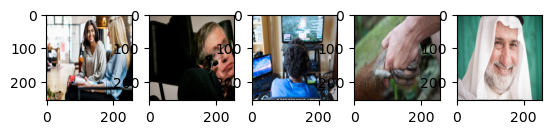

In [ ]:
h5file = 'test_db.h5'


with h5py.File(h5file, 'r') as db:
  label = db['label']
  text = db["text"]
  id = db["id"]
  images = db["image"]

  print(len(label))
    
  print(label[0:5])

  plt.figure()
  
  # display test images
  f, axarr = plt.subplots(1,5) 
  axarr[0].imshow(images[0])
  axarr[1].imshow(images[1])
  axarr[2].imshow(images[2])
  axarr[3].imshow(images[3])
  axarr[4].imshow(images[4])
    

# Load Data

In [7]:
# Hyperparameters
batch_size = 32
lr = 1e-4
weight_decay = 1e-3
epochs = 10

In [8]:
# dataloaders
transform = transforms.ToTensor() # everything in HDF5 is already pre-resized to 256 x 256 

train_dataset = HMDataset_H5(h5_file="./training_db.h5", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# validation (for tracking performance during training)
validate_dataset = HMDataset_H5(h5_file="./validation_db.h5", transform=transform)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# testing (for generating final performance metrics)
test_dataset = HMDataset_H5(h5_file="./test_db.h5", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# BridgeTower Model

In [9]:
# Get Pretrained Model

processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")

model.to(device)

# freeze model
for param in model.parameters():
    param.requires_grad = False

## Test BridgeTower On Singular Batch


In [10]:
# Test Dataloader Batch

sample_batch = next(iter(train_dataloader))


torch.Size([3, 256, 256])
tensor(58096, dtype=torch.int32)
tensor(0, dtype=torch.int32)
grandma is not getting run over by a reindeer this year!!


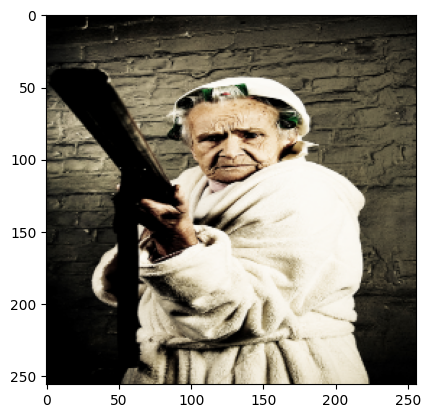

In [11]:
image = sample_batch["image"][0]
id = sample_batch["id"][0]
label = sample_batch["label"][0]
text = sample_batch["text"][0]

print(image.shape)

print(id)
print(label)
print(text)
plt.imshow(image.numpy().transpose((1, 2, 0)))


In [12]:
# Test Model on Batch

image_batch = list(sample_batch["image"].detach().numpy())  # processor wants list (batch) of np.arrays
text_batch = sample_batch["text"]

inputs = processor(image_batch, text_batch, return_tensors="pt", padding=True).to(device)
outputs = model(**inputs)

In [13]:
print(outputs.keys())
print(outputs["text_features"].shape)
print(outputs["image_features"].shape)
print(outputs["pooler_output"].shape)

print(sample_batch["label"].shape)

odict_keys(['text_features', 'image_features', 'pooler_output'])
torch.Size([32, 36, 768])
torch.Size([32, 325, 768])
torch.Size([32, 1536])
torch.Size([32])


In [14]:
print(outputs["pooler_output"])
print(torch.min(outputs["pooler_output"]))
print(torch.max(outputs["pooler_output"]))

# looks like no need for normalization

tensor([[-0.0040,  0.8552,  0.0102,  ..., -0.0308, -0.7916,  0.2962],
        [ 0.0139,  0.8336,  0.0278,  ..., -0.1306, -0.9018,  0.2261],
        [ 0.0187,  0.8246,  0.0146,  ...,  0.0857,  0.9975, -0.9870],
        ...,
        [-0.0350,  0.8160,  0.0379,  ..., -0.1701,  0.9889, -0.7291],
        [-0.0449,  0.8260,  0.0033,  ...,  0.0472,  0.9990, -0.9962],
        [-0.0204,  0.8523,  0.0299,  ...,  0.1130, -0.9871,  0.9797]],
       device='cuda:0')
tensor(-1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')


## Model Head

In [15]:
head = BridgeTowerHead()
head.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(head.parameters(), lr=lr, weight_decay=weight_decay)

# Training and Validation

In [16]:
def get_metrics_and_losses(losses, predictions, labels):
  average_loss = losses.mean().item()
  accuracy = (predictions == labels).sum().item() / labels.numel()

  # print(predictions)
  # print(labels)
  auroc = binary_auroc(predictions, labels)

  return average_loss, accuracy, auroc

## Test Loading Times / HDF5 Dataset

In [ ]:
# test loading batches using prev dataloader # almost 2 min for 5 batches
for i, data in enumerate(train_dataloader):
  print(i)
  if i > 5:
    break

In [ ]:
# Looks Lke Using HDF5 is Faster even in Colab - need to test using GPU (got kicked off rip)

# seems to be faster after first run ... idk why

# test loading batches using hdf5 dataloader
for i, data in enumerate(train_h5_dataloader):
  print(i)
  if i > 5:
    break

## Test 1 Batch of Training Loop

In [17]:
sample_batch = next(iter(train_dataloader))


when you tease your husband in public
tensor(0, dtype=torch.int32)


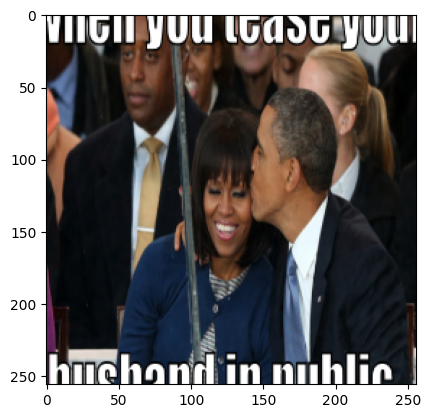

In [18]:
image = sample_batch["image"][0]
id = sample_batch["id"][0]
label = sample_batch["label"][0]
text = sample_batch["text"][0]

print(text)
print(label)
plt.imshow(image.detach().numpy().transpose(1, 2, 0))

inputs = processor(image, text, return_tensors="pt", padding=True).to(device)

# HDF5 Works so far  - test full training loop on GPU

In [19]:
softmax = nn.Softmax(dim=-1)

In [20]:
# get inputs
text = sample_batch['text']
image = list(sample_batch['image'].detach().numpy())
labels = sample_batch['label'].to(device).to(torch.int64)

# BridgeTower base model
inputs = processor(image, text, return_tensors="pt", padding=True).to(device)
bt_outputs = model(**inputs)
pooled_outputs = bt_outputs["pooler_output"]

image_out = bt_outputs["image_features"]
text_out = bt_outputs["text_features"]

# classification head
scores = torch.squeeze(head(pooled_outputs))
predictions = scores.argmax(dim=-1)



print(softmax(scores))
print(predictions)
print(labels)

# backprop
loss = criterion(scores, labels)
loss.backward()
optimizer.step()

train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(loss, predictions, labels)

print(train_average_loss)
print(train_accuracy)
print(train_auroc)


tensor([[0.4872, 0.5128],
        [0.4915, 0.5085],
        [0.5090, 0.4910],
        [0.4858, 0.5142],
        [0.4844, 0.5156],
        [0.5028, 0.4972],
        [0.4792, 0.5208],
        [0.4842, 0.5158],
        [0.4647, 0.5353],
        [0.4815, 0.5185],
        [0.4641, 0.5359],
        [0.4976, 0.5024],
        [0.4741, 0.5259],
        [0.5092, 0.4908],
        [0.4697, 0.5303],
        [0.5118, 0.4882],
        [0.4892, 0.5108],
        [0.4943, 0.5057],
        [0.4712, 0.5288],
        [0.4948, 0.5052],
        [0.4762, 0.5238],
        [0.5059, 0.4941],
        [0.4797, 0.5203],
        [0.4668, 0.5332],
        [0.4963, 0.5037],
        [0.4938, 0.5062],
        [0.4926, 0.5074],
        [0.5133, 0.4867],
        [0.5151, 0.4849],
        [0.4597, 0.5403],
        [0.4785, 0.5215],
        [0.4693, 0.5307]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1], device='c

## Full Training Loop

runtime from 1-2+ hrs per batch -> 8-10 mins per batch using HDF5

In [ ]:
# train model head
max_validation_auroc = 0

for e in range(epochs):

  # training
  train_losses = torch.zeros(len(train_dataloader)).to(device)
  train_predictions = torch.Tensor().to(device)
  train_labels = torch.Tensor().to(device)

  model.train()
  head.train()

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(e+1) + " Training"):

    # get inputs
    text = data['text']
    image = list(data['image'].detach().numpy())
    labels = data['label'].to(device).to(torch.int64)

    # zero the parameter gradients
    optimizer.zero_grad()

    # BridgeTower base model - this is what's taking long :/
    inputs = processor(image, text, return_tensors="pt", padding=True).to(device)
    bt_outputs = model(**inputs)
    pooled_outputs = bt_outputs["pooler_output"]

    # classification head
    scores = torch.squeeze(head(pooled_outputs))
    predictions = scores.argmax(dim=-1)

    # print(scores)

    # backprop
    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()

    # track values for metric logging
    train_losses[i] = loss
    train_predictions = torch.cat((train_predictions, predictions))
    train_labels = torch.cat((train_labels, labels))

    train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(train_losses, train_predictions, train_labels)

  # validation
  validate_losses = torch.zeros(len(validate_dataloader)).to(device)
  validate_predictions = torch.Tensor().to(device)
  validate_labels = torch.Tensor().to(device)

  model.eval()
  head.eval()

  with torch.no_grad():
    for i, data in tqdm(enumerate(validate_dataloader), total=len(validate_dataloader), desc="Epoch " + str(e+1) + " Training"):

      # get inputs
      text = data['text']
      image = list(data['image'].detach().numpy())
      labels = data['label'].to(device).to(torch.int64)

      # BridgeTower base model
      inputs = processor(image, text, return_tensors="pt", padding=True).to(device)
      bt_outputs = model(**inputs)
      pooled_outputs = bt_outputs["pooler_output"]

      # classification head
      scores = torch.squeeze(head(pooled_outputs))
      predictions = scores.argmax(dim=-1)

      # loss
      loss = criterion(scores, labels)

      # track values for metric logging
      validate_losses[i] = loss
      validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
      validate_labels = torch.cat((validate_labels, labels), dim=0)

  validate_average_loss, validate_accuracy, validate_auroc = get_metrics_and_losses(validate_losses, validate_predictions, validate_labels)

  # save model
  if validate_auroc > max_validation_auroc:
    max_validation_auroc = validate_auroc
    torch.save(head, "./models/bridgetower_" + str(e+1) + ".pt")
    print("New model saved at epoch " + str(e+1))

  print("Epoch %d" % (e+1))
  print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_average_loss, validate_average_loss))
  print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, validate_accuracy))
  print("Training AUROC: %.4f. Validation AUROC: %.4f. " % (train_auroc, validate_auroc))
  print("-----------------------------------")


# also overfitting problem
# add dropout
# weight decay (added by default)
# batch norm - doesnt seem to be needed, outputs alrdy normed from BT model


# 81 min training loop - send help

Epoch 1 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


New model saved at epoch 1
Epoch 1
Training Loss: 0.6235. Validation Loss: 0.7577. 
Training Accuracy: 0.6620. Validation Accuracy: 0.5120. 
Training AUROC: 0.5504. Validation AUROC: 0.5062. 
-----------------------------------


Epoch 2 Training: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


New model saved at epoch 2
Epoch 2
Training Loss: 0.5821. Validation Loss: 0.7441. 
Training Accuracy: 0.6908. Validation Accuracy: 0.5480. 
Training AUROC: 0.6051. Validation AUROC: 0.5431. 
-----------------------------------


Epoch 3 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Epoch 3
Training Loss: 0.5713. Validation Loss: 0.7504. 
Training Accuracy: 0.7046. Validation Accuracy: 0.5460. 
Training AUROC: 0.6330. Validation AUROC: 0.5413. 
-----------------------------------


Epoch 4 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


New model saved at epoch 4
Epoch 4
Training Loss: 0.5558. Validation Loss: 0.7550. 
Training Accuracy: 0.7191. Validation Accuracy: 0.5600. 
Training AUROC: 0.6528. Validation AUROC: 0.5557. 
-----------------------------------


Epoch 5 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


New model saved at epoch 5
Epoch 5
Training Loss: 0.5499. Validation Loss: 0.6582. 
Training Accuracy: 0.7171. Validation Accuracy: 0.6200. 
Training AUROC: 0.6527. Validation AUROC: 0.6192. 
-----------------------------------


Epoch 6 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Epoch 6
Training Loss: 0.5450. Validation Loss: 0.6632. 
Training Accuracy: 0.7275. Validation Accuracy: 0.6100. 
Training AUROC: 0.6681. Validation AUROC: 0.6093. 
-----------------------------------


Epoch 7 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Epoch 7
Training Loss: 0.5414. Validation Loss: 0.7086. 
Training Accuracy: 0.7262. Validation Accuracy: 0.6040. 
Training AUROC: 0.6711. Validation AUROC: 0.6005. 
-----------------------------------


Epoch 8 Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Epoch 8
Training Loss: 0.5429. Validation Loss: 0.7910. 
Training Accuracy: 0.7286. Validation Accuracy: 0.5680. 
Training AUROC: 0.6705. Validation AUROC: 0.5635. 
-----------------------------------


Epoch 9 Training: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Epoch 9
Training Loss: 0.5343. Validation Loss: 0.6931. 
Training Accuracy: 0.7352. Validation Accuracy: 0.6020. 
Training AUROC: 0.6808. Validation AUROC: 0.6003. 
-----------------------------------


Epoch 10 Training: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Epoch 10
Training Loss: 0.5315. Validation Loss: 0.9023. 
Training Accuracy: 0.7332. Validation Accuracy: 0.5420. 
Training AUROC: 0.6791. Validation AUROC: 0.5367. 
-----------------------------------
